In [1]:
%matplotlib inline

import cv2
import numpy as np
import os
import dlib
import matplotlib.pyplot as plt
from imutils.face_utils import FaceAligner

In [6]:
# required detectors and networks

# opencv dnn face detector
model_face_detect = {
    "proto": "./models/face_detect/deploy.prototxt.txt",
    "model": "./models/face_detect/res10_300x300_ssd_iter_140000.caffemodel"
}

face_detector = cv2.dnn.readNetFromCaffe(model_face_detect["proto"], model_face_detect["model"])

# dlib face landmark detector
predictor = dlib.shape_predictor('./models/face_landmark/shape_predictor_68_face_landmarks.dat')

# face aligner
face_aligner = FaceAligner(predictor, desiredFaceWidth=256)

# vgg face netowrk
vgg_face = cv2.dnn.readNetFromCaffe('./models/vgg_face/VGG_FACE_deploy.prototxt', './models/vgg_face/VGG_FACE.caffemodel')

In [3]:
# load trained svm
import pickle

with open('./output/svc_vgg_face.model', 'rb') as f:
    svc = pickle.load(f)

people = ['chiao', 'kaze', 'kiki', 'real', 'ricebug', 'tsungchan', 'tsungyu']

In [81]:
def run_img_classification(img_name):
    img = cv2.imread(img_name)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    img_draw = img.copy()

    # detect faces
    blob = cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)), 1.0, (300, 300), (104, 177, 123))
    face_detector.setInput(blob)
    detections = face_detector.forward()

    for i in range(detections.shape[2]):
        confidence = detections[0,0,i,2]
        if confidence < 0.8:
            continue
        box = detections[0, 0, i, 3:7] * [img.shape[1], img.shape[0], img.shape[1], img.shape[0]]
        box = box.astype('int')
        rect = dlib.rectangle(box[0], box[1], box[2], box[3])

        # face alignment
        aligned_face = face_aligner.align(img, img_gray, rect)

        # vgg face
        faceBlob = cv2.dnn.blobFromImage(aligned_face, 1.0, (224, 224), (129.1863, 104.7624, 93.5940), swapRB=True, crop=False)    
        vgg_face.setInput(faceBlob)
        descriptor = vgg_face.forward('fc7')
        descriptor /= 9.411078

        # predict
        y = svc.predict(descriptor)
        name = people[y[0]]

        # draw result
        cv2.rectangle(img_draw, (box[0], box[1]), (box[2], box[3]), (0,255,0), thickness=2)
        cv2.putText(img_draw, name, (box[0], box[3]+10), 
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.0015*img_draw.shape[1], 
                    color=(0,0,255), thickness=2)

    plt.figure(figsize=(10, 10))    
    plt.imshow(cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB))

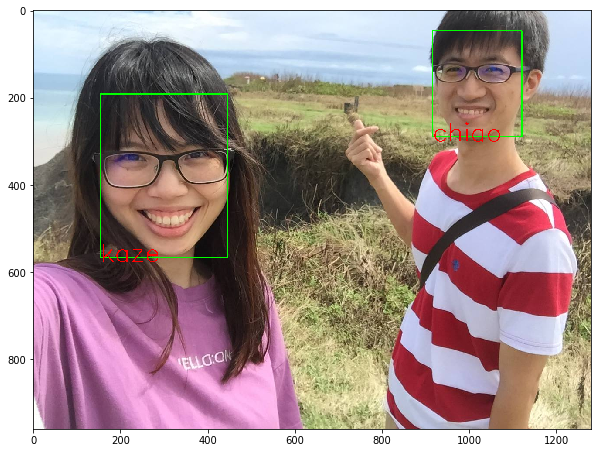

In [82]:
run_img_classification('./images/testing/multi/img_02.jpg')

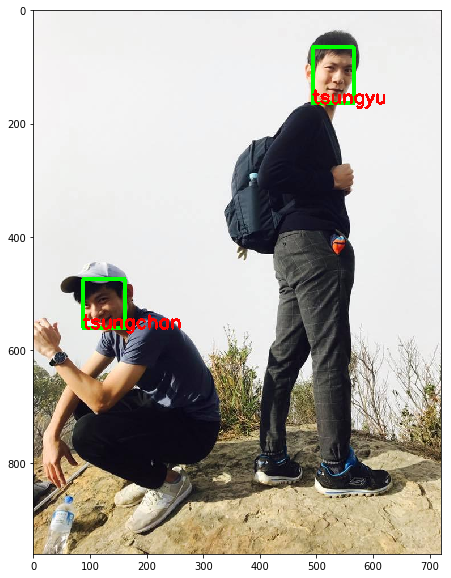

In [67]:
run_img_classification('./images/testing/multi/img_12.jpg')

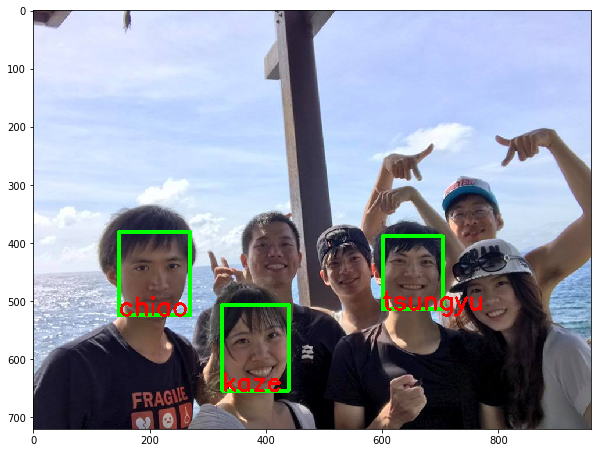

In [68]:
run_img_classification('./images/testing/multi/img_05.jpg')

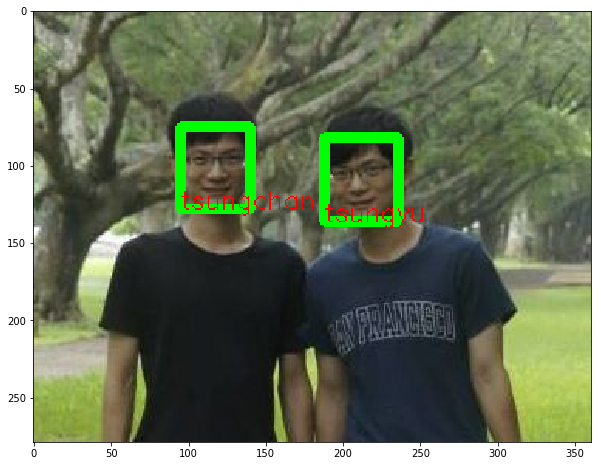

In [71]:
run_img_classification('./images/testing/multi/img_15.jpg')

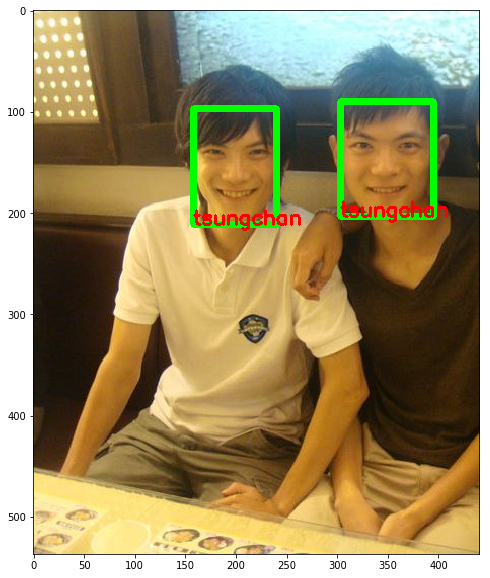

In [74]:
run_img_classification('./images/testing/multi/img_17.jpg')

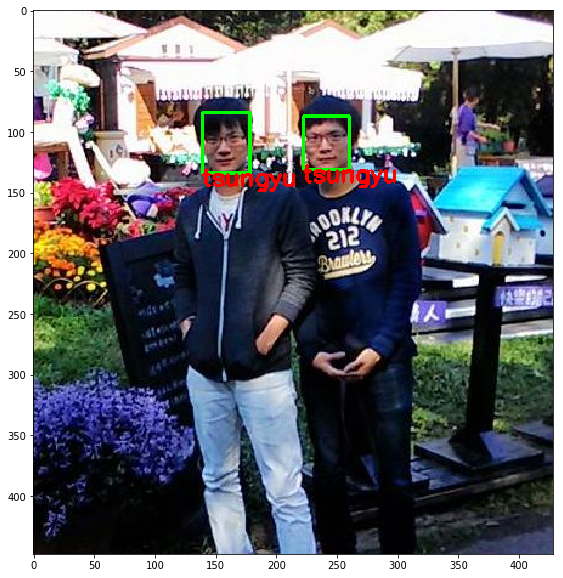

In [83]:
run_img_classification('./images/testing/multi/img_14.jpg')